In [1]:
import pandas as pd
import datetime
import pytz
import plotly.graph_objects as go
from plotly.offline import iplot
from plotly.subplots import make_subplots
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import plotly.io as pio

import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold


In [5]:

df=pd.read_csv("price_window.csv")


df['Datetime_CST'] = pd.to_datetime(df['Datetime_CST'], errors='coerce', utc=True)
df['Release_Datetime'] = pd.to_datetime(df['Release_Datetime'], errors='coerce', utc=True)

df['Time_to_Release_Minutes'] = (df['Datetime_CST'] - df['Release_Datetime']).dt.total_seconds() / 60

valid_releases = df.loc[df['Time_to_Release_Minutes'] == 2]
display(valid_releases['Date'])
display(df['Date'])
df = df[df['Date'].isin(valid_releases['Date'])]
df = df[df['Time_to_Release_Minutes'] <= 2]
display(df)
df.to_csv("price_window_valid.csv", index=False)

62       09/03/2011
183      16/03/2011
304      23/03/2011
425      30/03/2011
546      06/04/2011
            ...    
87908    05/02/2025
88029    12/02/2025
88150    20/02/2025
88271    26/02/2025
88392    05/03/2025
Name: Date, Length: 731, dtype: object

0        09/03/2011
1        09/03/2011
2        09/03/2011
3        09/03/2011
4        09/03/2011
            ...    
88446    05/03/2025
88447    05/03/2025
88448    05/03/2025
88449    05/03/2025
88450    05/03/2025
Name: Date, Length: 88451, dtype: object

,Datetime_CST,Date,Time,Open,High,Low,Close,Volume,Datetime,Percent_Change,Release_Datetime,Time_to_Release_Minutes
0,2011-03-09 14:30:00+00:00,09/03/2011,08:30:00,105.56,105.56,105.44,105.46,514.0,2011-03-09 08:30:00,-0.094733,2011-03-09 15:30:00+00:00,-60.0
1,2011-03-09 14:31:00+00:00,09/03/2011,08:31:00,105.46,105.52,105.45,105.46,323.0,2011-03-09 08:31:00,0.000000,2011-03-09 15:30:00+00:00,-59.0
2,2011-03-09 14:32:00+00:00,09/03/2011,08:32:00,105.45,105.47,105.31,105.32,899.0,2011-03-09 08:32:00,-0.132752,2011-03-09 15:30:00+00:00,-58.0
3,2011-03-09 14:33:00+00:00,09/03/2011,08:33:00,105.31,105.37,105.25,105.33,716.0,2011-03-09 08:33:00,0.009495,2011-03-09 15:30:00+00:00,-57.0
4,2011-03-09 14:34:00+00:00,09/03/2011,08:34:00,105.34,105.45,105.31,105.40,660.0,2011-03-09 08:34:00,0.066458,2011-03-09 15:30:00+00:00,-56.0
...,...,...,...,...,...,...,...,...,...,...,...,...
88388,2025-03-05 15:28:00+00:00,05/03/2025,09:28:00,66.18,66.28,66.16,66.27,486.0,2025-03-05 09:28:00,0.135993,2025-03-05 15:30:00+00:00,-2.0
88389,2025-03-05 15:29:00+00:00,05/03/2025,09:29:00,66.27,66.31,66.19,66.22,587.0,2025-03-05 09:29:00,-0.075449,2025-03-05 15:30:00+00:00,-1.0
88390,2025-03-05 15:30:00+00:00,05/03/2025,09:30:00,66.21,66.32,66.10,66.22,940.0,2025-03-05 09:30:00,0.000000,2025-03-05 15:30:00+00:00,0.0
88391,2025-03-05 15:31:00+00:00,05/03/2025,09:31:00,66.22,66.32,66.22,66.25,644.0,2025-03-05 09:31:00,0.045304,2025-03-05 15:30:00+00:00,1.0


In [6]:
def pivot_market_data(df, x_minutes_before, cols_to_pivot=None):
    """
    pivot into wide formate where minutes to release from [-x, 2] are kept as columns for each feature.
    """
    if cols_to_pivot is None:
        cols_to_pivot = ['Open', 'High', 'Low', 'Close', 'Volume']

    df_filtered = df[(df['Time_to_Release_Minutes'] <= 2) & (df['Time_to_Release_Minutes'] >= -x_minutes_before)].copy()

    df_long = df_filtered.melt(
        id_vars=['Datetime', 'Time_to_Release_Minutes', 'Release_Datetime'],
        value_vars=cols_to_pivot,
        var_name='Feature',
        value_name='Value'
    )
    df_long['Feature_min'] = df_long['Feature'] + '_t' + df_long['Time_to_Release_Minutes'].astype(int).astype(str)

    df_wide = df_long.pivot_table(
        index='Release_Datetime',
        columns='Feature_min',
        values='Value'
    ).reset_index()
    cols_to_drop = [col for col in df_wide.columns if 't2' in col and col != 'Close_t2']
    df_wide.drop(columns=cols_to_drop, inplace=True)
    return df_wide

df_wide = pivot_market_data(df, x_minutes_before=60)
display(df_wide)

#df_wide['Date'] = df_wide.apply(lambda x: x['Release_Datetime'].split()[0], axis=1)

display(df_wide.isna().sum().where(df_wide.isna().sum() > 0))

display(df_wide)

df_wide.to_csv("price_window_valid_wide.csv", index=False)



Feature_min,Release_Datetime,Close_t-1,Close_t-10,Close_t-11,Close_t-12,Close_t-13,Close_t-14,Close_t-15,Close_t-16,Close_t-17,...,Volume_t-57,Volume_t-58,Volume_t-59,Volume_t-6,Volume_t-60,Volume_t-7,Volume_t-8,Volume_t-9,Volume_t0,Volume_t1
0,2011-03-09 15:30:00+00:00,105.13,105.15,105.14,105.17,105.19,105.20,105.20,105.33,105.20,...,716.0,899.0,323.0,318.0,514.0,138.0,254.0,252.0,2458.0,2052.0
1,2011-03-16 13:30:00+00:00,98.38,98.44,98.35,98.39,98.35,98.35,98.43,98.53,98.63,...,102.0,127.0,232.0,275.0,401.0,491.0,262.0,190.0,588.0,473.0
2,2011-03-23 13:30:00+00:00,105.36,105.26,105.21,105.19,105.15,105.12,105.02,105.03,105.04,...,262.0,350.0,121.0,111.0,187.0,187.0,466.0,412.0,325.0,983.0
3,2011-03-30 13:30:00+00:00,104.34,104.35,104.36,104.36,104.42,104.39,104.40,104.40,104.40,...,128.0,119.0,201.0,133.0,484.0,382.0,548.0,188.0,280.0,292.0
4,2011-04-06 13:30:00+00:00,108.62,108.48,108.52,108.55,108.52,108.54,108.53,108.59,108.59,...,115.0,29.0,26.0,265.0,37.0,199.0,182.0,86.0,556.0,567.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,2025-02-05 15:30:00+00:00,71.66,71.61,71.60,71.54,71.53,71.57,71.55,71.61,71.63,...,284.0,313.0,319.0,246.0,547.0,206.0,379.0,513.0,2069.0,929.0
727,2025-02-12 15:30:00+00:00,72.10,72.04,72.09,72.11,72.07,72.07,72.05,72.02,72.05,...,476.0,188.0,202.0,159.0,491.0,109.0,183.0,140.0,1269.0,515.0
728,2025-02-20 17:00:00+00:00,72.71,72.75,72.72,72.71,72.70,72.72,72.75,72.77,72.77,...,111.0,166.0,140.0,100.0,158.0,109.0,76.0,94.0,932.0,325.0
729,2025-02-26 15:00:00+00:00,68.93,68.94,68.89,68.86,68.88,68.94,68.93,68.83,68.82,...,571.0,640.0,1314.0,160.0,989.0,226.0,263.0,260.0,477.0,349.0


Feature_min
Release_Datetime   NaN
Close_t-1          NaN
Close_t-10         NaN
Close_t-11         NaN
Close_t-12         NaN
                    ..
Volume_t-7         NaN
Volume_t-8         NaN
Volume_t-9         NaN
Volume_t0          NaN
Volume_t1          NaN
Length: 312, dtype: float64

Feature_min,Release_Datetime,Close_t-1,Close_t-10,Close_t-11,Close_t-12,Close_t-13,Close_t-14,Close_t-15,Close_t-16,Close_t-17,...,Volume_t-57,Volume_t-58,Volume_t-59,Volume_t-6,Volume_t-60,Volume_t-7,Volume_t-8,Volume_t-9,Volume_t0,Volume_t1
0,2011-03-09 15:30:00+00:00,105.13,105.15,105.14,105.17,105.19,105.20,105.20,105.33,105.20,...,716.0,899.0,323.0,318.0,514.0,138.0,254.0,252.0,2458.0,2052.0
1,2011-03-16 13:30:00+00:00,98.38,98.44,98.35,98.39,98.35,98.35,98.43,98.53,98.63,...,102.0,127.0,232.0,275.0,401.0,491.0,262.0,190.0,588.0,473.0
2,2011-03-23 13:30:00+00:00,105.36,105.26,105.21,105.19,105.15,105.12,105.02,105.03,105.04,...,262.0,350.0,121.0,111.0,187.0,187.0,466.0,412.0,325.0,983.0
3,2011-03-30 13:30:00+00:00,104.34,104.35,104.36,104.36,104.42,104.39,104.40,104.40,104.40,...,128.0,119.0,201.0,133.0,484.0,382.0,548.0,188.0,280.0,292.0
4,2011-04-06 13:30:00+00:00,108.62,108.48,108.52,108.55,108.52,108.54,108.53,108.59,108.59,...,115.0,29.0,26.0,265.0,37.0,199.0,182.0,86.0,556.0,567.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,2025-02-05 15:30:00+00:00,71.66,71.61,71.60,71.54,71.53,71.57,71.55,71.61,71.63,...,284.0,313.0,319.0,246.0,547.0,206.0,379.0,513.0,2069.0,929.0
727,2025-02-12 15:30:00+00:00,72.10,72.04,72.09,72.11,72.07,72.07,72.05,72.02,72.05,...,476.0,188.0,202.0,159.0,491.0,109.0,183.0,140.0,1269.0,515.0
728,2025-02-20 17:00:00+00:00,72.71,72.75,72.72,72.71,72.70,72.72,72.75,72.77,72.77,...,111.0,166.0,140.0,100.0,158.0,109.0,76.0,94.0,932.0,325.0
729,2025-02-26 15:00:00+00:00,68.93,68.94,68.89,68.86,68.88,68.94,68.93,68.83,68.82,...,571.0,640.0,1314.0,160.0,989.0,226.0,263.0,260.0,477.0,349.0


Starting with xgboost on just the price data as a baseline

In [7]:
price_window_wide = pd.read_csv('price_window_valid_wide.csv')

display(price_window_wide)


,Release_Datetime,Close_t-1,Close_t-10,Close_t-11,Close_t-12,Close_t-13,Close_t-14,Close_t-15,Close_t-16,Close_t-17,...,Volume_t-57,Volume_t-58,Volume_t-59,Volume_t-6,Volume_t-60,Volume_t-7,Volume_t-8,Volume_t-9,Volume_t0,Volume_t1
0,2011-03-09 15:30:00+00:00,105.13,105.15,105.14,105.17,105.19,105.20,105.20,105.33,105.20,...,716.0,899.0,323.0,318.0,514.0,138.0,254.0,252.0,2458.0,2052.0
1,2011-03-16 13:30:00+00:00,98.38,98.44,98.35,98.39,98.35,98.35,98.43,98.53,98.63,...,102.0,127.0,232.0,275.0,401.0,491.0,262.0,190.0,588.0,473.0
2,2011-03-23 13:30:00+00:00,105.36,105.26,105.21,105.19,105.15,105.12,105.02,105.03,105.04,...,262.0,350.0,121.0,111.0,187.0,187.0,466.0,412.0,325.0,983.0
3,2011-03-30 13:30:00+00:00,104.34,104.35,104.36,104.36,104.42,104.39,104.40,104.40,104.40,...,128.0,119.0,201.0,133.0,484.0,382.0,548.0,188.0,280.0,292.0
4,2011-04-06 13:30:00+00:00,108.62,108.48,108.52,108.55,108.52,108.54,108.53,108.59,108.59,...,115.0,29.0,26.0,265.0,37.0,199.0,182.0,86.0,556.0,567.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,2025-02-05 15:30:00+00:00,71.66,71.61,71.60,71.54,71.53,71.57,71.55,71.61,71.63,...,284.0,313.0,319.0,246.0,547.0,206.0,379.0,513.0,2069.0,929.0
727,2025-02-12 15:30:00+00:00,72.10,72.04,72.09,72.11,72.07,72.07,72.05,72.02,72.05,...,476.0,188.0,202.0,159.0,491.0,109.0,183.0,140.0,1269.0,515.0
728,2025-02-20 17:00:00+00:00,72.71,72.75,72.72,72.71,72.70,72.72,72.75,72.77,72.77,...,111.0,166.0,140.0,100.0,158.0,109.0,76.0,94.0,932.0,325.0
729,2025-02-26 15:00:00+00:00,68.93,68.94,68.89,68.86,68.88,68.94,68.93,68.83,68.82,...,571.0,640.0,1314.0,160.0,989.0,226.0,263.0,260.0,477.0,349.0


In [8]:
import xgboost as xgb


column_names = []
variable_names = ['Close', 'Open', 'High', 'Low', 'Volume']
for var_name in variable_names:
    for min in range(60):
        column_names.append(f'{var_name}_t{min-60}')

column_names.append('Close_t2')
column_names.append('Open_t0')

print(column_names)

display(price_window_wide.columns)
print(len(column_names))

X = price_window_wide[column_names]
y = price_window_wide['Close_t2']


n_estimators_grid = [200, 400, 600]
alpha_grid = [10**-k for k in [1, 3, 5, 7]]

tscv = TimeSeriesSplit(n_splits=3)
results = []

for fold, (train_index_full, test_index_full) in enumerate(tscv.split(X)):

    X_train_fold_full, y_train_fold_full = X.iloc[train_index_full], y.iloc[train_index_full]
    X_test_fold_full, y_test_fold_full = X.iloc[test_index_full], y.iloc[test_index_full]

    test_fold_length = len(X_test_fold_full)
    val_length = test_fold_length // 2

    X_val, y_val = X_test_fold_full.iloc[:val_length], y_test_fold_full.iloc[:val_length]

    X_train_sampled = X_train_fold_full.sample(frac=0.1, random_state=42)

    y_train_sampled = y_train_fold_full.loc[X_train_sampled.index]

    for n_est in n_estimators_grid:
        for alpha in alpha_grid:

            model = xgb.XGBRegressor(n_estimators=n_est,
                                     reg_alpha=alpha, # Using alpha_val for L1 regularization
                                     random_state=42,
                                     n_jobs=-1,
                                     objective='reg:squarederror')

            model.fit(X_train_sampled, np.ravel(y_train_sampled))

            y_pred_val = model.predict(X_val)

            val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))

            results.append({
                'n_estimators': n_est,
                'ccp_alpha': alpha,
                'fold': fold + 1,
                'val_rmse': val_rmse
            })

results_df = pd.DataFrame(results)

average_rmse_across_folds = results_df.groupby(['n_estimators', 'ccp_alpha'])['val_rmse'].mean().reset_index()

best_params_row = average_rmse_across_folds.loc[average_rmse_across_folds['val_rmse'].idxmin()]

best_n_estimators = best_params_row['n_estimators']
best_alpha = best_params_row['ccp_alpha']
best_avg_rmse = best_params_row['val_rmse']

print("Best hyperparameters:")
print(f"  n_estimators: {best_n_estimators}")

print(f"  ccp_alpha: {best_alpha}")
print(f"  Average Validation RMSE: {best_avg_rmse:.4f}")


['Close_t-60', 'Close_t-59', 'Close_t-58', 'Close_t-57', 'Close_t-56', 'Close_t-55', 'Close_t-54', 'Close_t-53', 'Close_t-52', 'Close_t-51', 'Close_t-50', 'Close_t-49', 'Close_t-48', 'Close_t-47', 'Close_t-46', 'Close_t-45', 'Close_t-44', 'Close_t-43', 'Close_t-42', 'Close_t-41', 'Close_t-40', 'Close_t-39', 'Close_t-38', 'Close_t-37', 'Close_t-36', 'Close_t-35', 'Close_t-34', 'Close_t-33', 'Close_t-32', 'Close_t-31', 'Close_t-30', 'Close_t-29', 'Close_t-28', 'Close_t-27', 'Close_t-26', 'Close_t-25', 'Close_t-24', 'Close_t-23', 'Close_t-22', 'Close_t-21', 'Close_t-20', 'Close_t-19', 'Close_t-18', 'Close_t-17', 'Close_t-16', 'Close_t-15', 'Close_t-14', 'Close_t-13', 'Close_t-12', 'Close_t-11', 'Close_t-10', 'Close_t-9', 'Close_t-8', 'Close_t-7', 'Close_t-6', 'Close_t-5', 'Close_t-4', 'Close_t-3', 'Close_t-2', 'Close_t-1', 'Open_t-60', 'Open_t-59', 'Open_t-58', 'Open_t-57', 'Open_t-56', 'Open_t-55', 'Open_t-54', 'Open_t-53', 'Open_t-52', 'Open_t-51', 'Open_t-50', 'Open_t-49', 'Open_t-48',

Index(['Release_Datetime', 'Close_t-1', 'Close_t-10', 'Close_t-11',
       'Close_t-12', 'Close_t-13', 'Close_t-14', 'Close_t-15', 'Close_t-16',
       'Close_t-17',
       ...
       'Volume_t-57', 'Volume_t-58', 'Volume_t-59', 'Volume_t-6',
       'Volume_t-60', 'Volume_t-7', 'Volume_t-8', 'Volume_t-9', 'Volume_t0',
       'Volume_t1'],
      dtype='object', length=312)

302
Best hyperparameters:
  n_estimators: 200.0
  ccp_alpha: 1e-05
  Average Validation RMSE: 13.2509


Test set RMSE for each fold:
  Fold 1: 26.50580147893311
  Fold 2: 3.4873631881880076
  Fold 3: 0.9822677291995981
RMSE of Best Fitting Model: 10.325144132106905


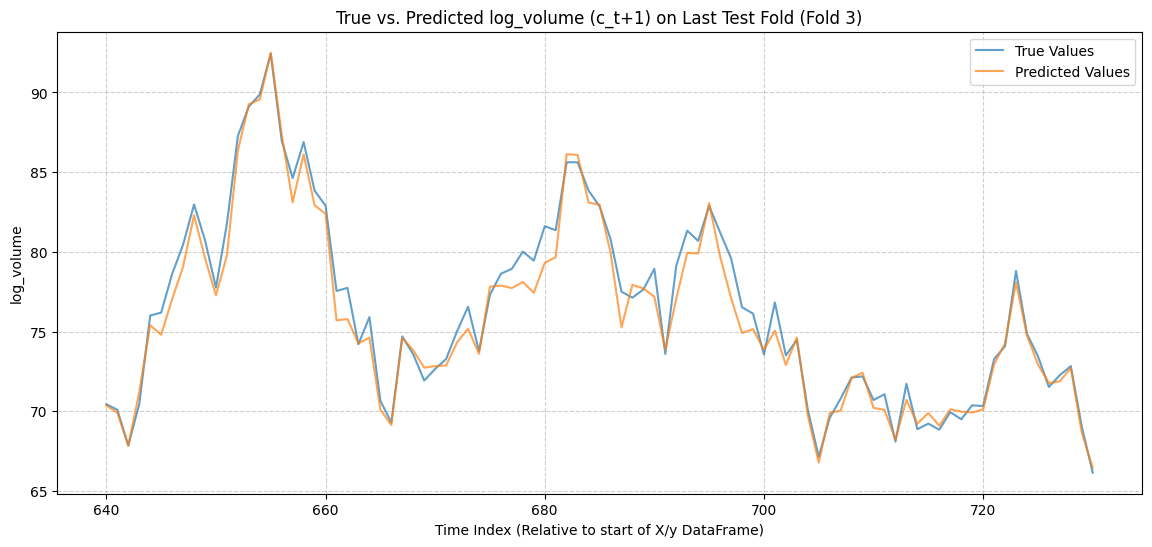

In [9]:
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)

test_rmses = []
last_fold_true = None
last_fold_pred = None

for fold, (train_index_full, test_index_full) in enumerate(tscv.split(X)):
    X_train_fold_full, y_train_fold_full = X.iloc[train_index_full], y.iloc[train_index_full]
    X_test_fold_full, y_test_fold_full = X.iloc[test_index_full], y.iloc[test_index_full]

    test_fold_length = len(X_test_fold_full)
    val_length = test_fold_length // 2

    X_test_final = X_test_fold_full.iloc[val_length:]
    y_test_final = y_test_fold_full.iloc[val_length:]

    best_model = xgb.XGBRegressor(n_estimators=int(best_n_estimators),
                                       reg_alpha=best_alpha,
                                       random_state=42,
                                       n_jobs=-1)

    best_model.fit(X_train_fold_full, np.ravel(y_train_fold_full))

    y_pred_test = best_model.predict(X_test_final)

    test_rmse = np.sqrt(mean_squared_error(y_test_final, y_pred_test))
    test_rmses.append(test_rmse)

    if fold == n_splits - 1:
        last_fold_true = y_test_final.values
        last_fold_pred = y_pred_test
        last_fold_index = y_test_final.index

print("Test set RMSE for each fold:")
for i, rmse in enumerate(test_rmses):
    print(f"  Fold {i+1}: {rmse}")

print(f"RMSE of Best Fitting Model: {np.mean(test_rmses)}")


if last_fold_true is not None and last_fold_pred is not None:
    plt.figure(figsize=(14, 6))
    plt.plot(last_fold_index, last_fold_true, label='True Values', alpha=0.7)
    plt.plot(last_fold_index, last_fold_pred, label='Predicted Values', alpha=0.7)
    plt.title(f'True vs. Predicted log_volume (c_t+1) on Last Test Fold (Fold {n_splits})')
    plt.xlabel('Time Index (Relative to start of X/y DataFrame)')
    plt.ylabel('log_volume')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

C:\Users\evans\AppData\Local\Temp\ipykernel_59240\228438546.py:33: FutureWarning:

Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.

C:\Users\evans\AppData\Local\Temp\ipykernel_59240\228438546.py:33: FutureWarning:

Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.

C:\Users\evans\AppData\Local\Temp\ipykernel_59240\228438546.py:33: FutureWarning:

Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.

C:\Users\evans\AppData\Local\Temp\ipykernel_59240\228438546.py:33: FutureWarning:

Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.

C:\Users\evans\AppData\Local\Temp\ipykernel_59240\228438546.py:3

Optimal Parameters: (200, 0.001)
Minimum RMSE (Validation): [np.float64(32.9551739831209), np.float64(3.0425580367428875), np.float64(3.824736432397972)]


C:\Users\evans\AppData\Local\Temp\ipykernel_59240\228438546.py:48: FutureWarning:

Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.

C:\Users\evans\AppData\Local\Temp\ipykernel_59240\228438546.py:48: FutureWarning:

Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.

C:\Users\evans\AppData\Local\Temp\ipykernel_59240\228438546.py:48: FutureWarning:

Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.



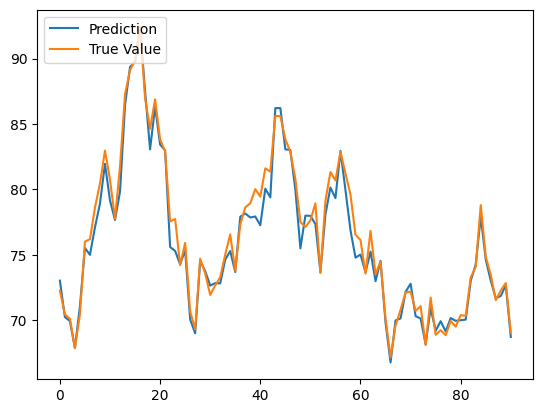

Minimum RMSE (test): 10.351697953904791


In [10]:
def time_series_valid_test(X, y, n_split, valid_or_test, n_estimators_list, ccp_alpha_list, optimal_par=None):
    np.random.seed(42)
    tscv = TimeSeriesSplit(n_splits=n_split)
    rf_rmse = []
    rmseSmall = []
    param_combinations = []  # param combo storagae
    i = 0  # fold counter
    for train_index, test_index in tscv.split(X):
        i += 1
        # Break test set into 50% validation set, 50% test set
        break_test_ind = int(test_index[0] + 0.5*(test_index[-1]-test_index[0]))
        valid_index = np.array(list(range(test_index[0],break_test_ind)))
        test_index = np.array(list(range(break_test_ind,test_index[-1])))

        # Split data into training, validation, and test sets
        X_train, X_valid, X_test = X.iloc[train_index], X.iloc[valid_index], X.iloc[test_index]
        y_train, y_valid, y_test = y.iloc[train_index], y.iloc[valid_index], y.iloc[test_index]

        # Tuning
        if valid_or_test == "valid":
            rf_rmse_fold = []
            for n_estimators in n_estimators_list:
                for ccp_alpha in ccp_alpha_list:
                    model_rf = xgb.XGBRegressor(random_state=42,
                                                n_estimators=n_estimators,
                                                reg_alpha=ccp_alpha,
                                                n_jobs=-1)


                    X_train_sample = X_train.sample(frac=0.1, random_state=42)
                    y_train_sample = y_train.loc[X_train_sample.index]

                    model_rf.fit(X_train_sample, y_train_sample.ravel())


                    y_val_rf = model_rf.predict(X_valid)
                    fold_rmse = np.sqrt(mean_squared_error(y_valid, y_val_rf))
                    rf_rmse_fold.append(fold_rmse)
                    param_combinations.append((n_estimators, ccp_alpha))

            rf_rmse.append(np.mean(rf_rmse_fold))

        if valid_or_test == "test":
            model_rf = xgb.XGBRegressor(random_state=42,
                                             n_estimators=optimal_par[0],
                                             reg_alpha=optimal_par[1],
                                             n_jobs=-1)
            model_rf.fit(X_train, y_train.ravel())
            y_test_rf = model_rf.predict(X_test)
            test_rmse = np.sqrt(mean_squared_error(y_test, y_test_rf))
            rf_rmse.append(test_rmse)
            rmseSmall.append(np.sqrt(np.sum((y_test.shift(-1)[:-1] - y_test[:-1])**2)/len(y_test.shift(-1))))

            # Plot the prediction for the last CV fold
            if i == n_split:
                plt.plot(range(len(X_test)), y_test_rf, label="Prediction")
                plt.plot(range(len(X_test)), y_test, label="True Value")
                plt.legend(loc="upper left")
                plt.show()

    # Return results
    if valid_or_test == "valid":
        min_rmse_idx = np.argmin(rf_rmse)  # Find index of lowest RMSE
        optimal_params = param_combinations[min_rmse_idx]  # Retrieve corresponding parameters
        return rf_rmse, optimal_params
    if valid_or_test == "test":
        rf_rmse = np.mean(rf_rmse)
        rmseSmallAns = np.mean(rmseSmall)
        return rf_rmse, y_test_rf, rmseSmallAns

n_estimators_list = [200, 400, 600]
ccp_alpha_list = [10**-2, 10**-3, 10**-5, 10**-7]


rf_rmse, optimal_params = time_series_valid_test(X, y, n_split = 3, valid_or_test = "valid",
                                                 n_estimators_list = n_estimators_list,
                                                 ccp_alpha_list = ccp_alpha_list)


print("Optimal Parameters:", optimal_params)
print("Minimum RMSE (Validation):", rf_rmse)

test_rmse, preddictions, smallRMSE = time_series_valid_test(X, y, n_split = 3, valid_or_test = "test",
                                                 n_estimators_list = n_estimators_list,
                                                 ccp_alpha_list = ccp_alpha_list,
                                                 optimal_par=optimal_params)

print("Minimum RMSE (test):", test_rmse)

In [11]:
#weekly_prod
#net_import_crude
#weekly_supply WCESTUS1


price_data = pd.read_csv('data/price_data_sorted.csv')
price_data['Release_Datetime'] = pd.to_datetime(price_data['Release_Datetime'], errors='coerce', utc=True)
price_data['Release Date'] = price_data['Release_Datetime'].dt.date
price_data = price_data.drop(columns=['Release_Datetime']).set_index('Release Date')

weekly_supply=pd.read_csv("InvestingcomEIA.csv")
weekly_supply['Release Date'] = pd.to_datetime(weekly_supply['Release Date'], format="%d-%b-%y").dt.strftime("%Y-%m-%d")
weekly_supply.set_index('Release Date', inplace=True)


weekly_prod=pd.read_csv("weekly_prod.csv", header=2)


weekly_import=pd.read_csv("net_import.csv")

In [12]:
display(price_data.dtypes)

Close_t-60     float64
High_t-60      float64
Low_t-60       float64
Open_t-60      float64
Volume_t-60    float64
                ...   
High_t1        float64
Low_t1         float64
Open_t1        float64
Volume_t1      float64
Close_t2       float64
Length: 311, dtype: object

In [13]:
price_data = price_data.sort_index()
price_data.reset_index(inplace=True)
weekly_supply = weekly_supply.sort_index()
weekly_supply.reset_index(inplace=True)
display(price_data)
display(weekly_supply)

,Release Date,Close_t-60,High_t-60,Low_t-60,Open_t-60,Volume_t-60,Close_t-59,High_t-59,Low_t-59,Open_t-59,...,High_t0,Low_t0,Open_t0,Volume_t0,Close_t1,High_t1,Low_t1,Open_t1,Volume_t1,Close_t2
0,2011-03-09,105.46,105.56,105.44,105.56,514.0,105.46,105.52,105.45,105.46,...,105.43,105.07,105.24,2458.0,105.36,105.48,105.21,105.33,2052.0,105.34
1,2011-03-16,98.82,98.89,98.77,98.88,401.0,98.78,98.84,98.73,98.82,...,98.44,98.28,98.40,588.0,98.48,98.55,98.44,98.44,473.0,98.56
2,2011-03-23,105.52,105.53,105.46,105.47,187.0,105.50,105.53,105.48,105.52,...,105.42,105.35,105.35,325.0,105.28,105.50,105.27,105.40,983.0,105.41
3,2011-03-30,104.65,104.67,104.56,104.60,484.0,104.65,104.65,104.57,104.64,...,104.37,104.29,104.34,280.0,104.36,104.40,104.35,104.37,292.0,104.33
4,2011-04-06,108.45,108.46,108.43,108.43,37.0,108.44,108.46,108.43,108.46,...,108.67,108.59,108.60,556.0,108.50,108.63,108.48,108.62,567.0,108.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,2025-02-05,71.71,71.72,71.63,71.67,547.0,71.74,71.78,71.71,71.71,...,71.68,71.40,71.65,2069.0,71.45,71.58,71.41,71.58,929.0,71.53
727,2025-02-12,72.05,72.09,72.02,72.08,491.0,72.07,72.09,72.04,72.04,...,72.28,72.08,72.08,1269.0,72.23,72.23,72.14,72.15,515.0,72.27
728,2025-02-20,72.52,72.53,72.48,72.50,158.0,72.53,72.53,72.48,72.52,...,72.79,72.64,72.71,932.0,72.82,72.82,72.76,72.79,325.0,72.84
729,2025-02-26,68.83,68.85,68.72,68.78,989.0,69.04,69.11,68.83,68.83,...,69.01,68.93,68.94,477.0,69.03,69.05,68.99,68.99,349.0,69.05


,Release Date,Time,Actual,Forecast,Previous
0,2011-03-09,10:30,2.500M,1.100M,-0.400M
1,2011-03-16,9:30,1.700M,1.800M,2.500M
2,2011-03-23,9:30,2.100M,2.000M,1.700M
3,2011-03-30,9:30,2.900M,2.000M,2.100M
4,2011-04-06,9:30,2.000M,1.300M,2.900M
...,...,...,...,...,...
727,2025-02-12,10:30,4.070M,2.400M,8.664M
728,2025-02-20,12:00,4.633M,3.200M,4.070M
729,2025-02-26,10:00,-2.332M,2.500M,4.633M
730,2025-03-05,10:30,3.614M,0.600M,-2.332M


In [14]:
price_data['Release Date'] = pd.to_datetime(price_data['Release Date'])
weekly_supply['Release Date'] = pd.to_datetime(weekly_supply['Release Date'])
display(price_data.dtypes)
display(weekly_supply.dtypes)
price_supply = pd.merge(price_data, weekly_supply, how='left', on='Release Date')
display(price_supply)

Release Date    datetime64[ns]
Close_t-60             float64
High_t-60              float64
Low_t-60               float64
Open_t-60              float64
                     ...      
High_t1                float64
Low_t1                 float64
Open_t1                float64
Volume_t1              float64
Close_t2               float64
Length: 312, dtype: object

Release Date    datetime64[ns]
Time                    object
Actual                  object
Forecast                object
Previous                object
dtype: object

,Release Date,Close_t-60,High_t-60,Low_t-60,Open_t-60,Volume_t-60,Close_t-59,High_t-59,Low_t-59,Open_t-59,...,Close_t1,High_t1,Low_t1,Open_t1,Volume_t1,Close_t2,Time,Actual,Forecast,Previous
0,2011-03-09,105.46,105.56,105.44,105.56,514.0,105.46,105.52,105.45,105.46,...,105.36,105.48,105.21,105.33,2052.0,105.34,10:30,2.500M,1.100M,-0.400M
1,2011-03-16,98.82,98.89,98.77,98.88,401.0,98.78,98.84,98.73,98.82,...,98.48,98.55,98.44,98.44,473.0,98.56,9:30,1.700M,1.800M,2.500M
2,2011-03-23,105.52,105.53,105.46,105.47,187.0,105.50,105.53,105.48,105.52,...,105.28,105.50,105.27,105.40,983.0,105.41,9:30,2.100M,2.000M,1.700M
3,2011-03-30,104.65,104.67,104.56,104.60,484.0,104.65,104.65,104.57,104.64,...,104.36,104.40,104.35,104.37,292.0,104.33,9:30,2.900M,2.000M,2.100M
4,2011-04-06,108.45,108.46,108.43,108.43,37.0,108.44,108.46,108.43,108.46,...,108.50,108.63,108.48,108.62,567.0,108.53,9:30,2.000M,1.300M,2.900M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730,2025-02-05,71.71,71.72,71.63,71.67,547.0,71.74,71.78,71.71,71.71,...,71.45,71.58,71.41,71.58,929.0,71.53,10:30,8.664M,2.400M,3.463M
731,2025-02-12,72.05,72.09,72.02,72.08,491.0,72.07,72.09,72.04,72.04,...,72.23,72.23,72.14,72.15,515.0,72.27,10:30,4.070M,2.400M,8.664M
732,2025-02-20,72.52,72.53,72.48,72.50,158.0,72.53,72.53,72.48,72.52,...,72.82,72.82,72.76,72.79,325.0,72.84,12:00,4.633M,3.200M,4.070M
733,2025-02-26,68.83,68.85,68.72,68.78,989.0,69.04,69.11,68.83,68.83,...,69.03,69.05,68.99,68.99,349.0,69.05,10:00,-2.332M,2.500M,4.633M


In [15]:

weekly_prod['Date'] = pd.to_datetime(weekly_prod['Date'])
weekly_import['Date'] = pd.to_datetime(weekly_import['Date'])

prod_import = pd.merge(weekly_import, weekly_prod, how='left', on='Date').dropna()
display(prod_import)

,Date,Weekly Net Import,Weekly U.S. Field Production of Crude Oil (Thousand Barrels per Day)
0,2001-11-09,9639.0,5863.0
1,2001-11-16,8879.0,5872.0
2,2001-11-23,8187.0,5882.0
3,2001-11-30,9856.0,5873.0
4,2001-12-07,8966.0,5856.0
...,...,...,...
1224,2025-04-25,1377.0,13465.0
1225,2025-05-02,2050.0,13367.0
1226,2025-05-09,2472.0,13387.0
1227,2025-05-16,2582.0,13392.0


In [16]:
mapping = pd.read_csv('FXmappings.csv')
split_data = mapping['Date'].str.split('(', expand=True)

mapping['ReleaseDate_str'] = split_data[0].str.strip()

mapping['end_date'] = split_data[1].str.rstrip(')').str.strip()

mapping['ReleaseDate'] = pd.to_datetime(mapping['ReleaseDate_str'], format='%m/%d/%Y')
mapping.drop(columns=['ReleaseDate_str', 'Date'], inplace=True)

release_year = mapping['ReleaseDate'].dt.year

full_end_date = mapping['end_date'] + ' ' + release_year.astype(str)

mapping['end_date'] = pd.to_datetime(full_end_date, format='%b %d %Y')

mapping['day_before'] = mapping['ReleaseDate'] - pd.Timedelta(days=1)

dow = mapping['day_before'].dt.dayofweek

days_to_subtract = (dow + 3) % 7

mapping['end_date'] = mapping['day_before'] - pd.to_timedelta(days_to_subtract, unit='D')

mapping.drop(columns=['day_before'], inplace=True)
mapping['end_date'] = pd.to_datetime(mapping['end_date'])
mapping = mapping.set_index('end_date').sort_index()
mapping.reset_index(inplace=True)

prod_import_mapped = pd.merge(mapping, prod_import, how='left', right_on='Date', left_on='end_date')
prod_import_mapped.drop(columns=['end_date', 'Date'], inplace=True)
print(prod_import_mapped.dtypes)
display(prod_import_mapped)

full_data = pd.merge(price_supply, prod_import_mapped, how='left', left_on='Release Date', right_on='ReleaseDate')


ReleaseDate                                                              datetime64[ns]
Weekly Net Import                                                               float64
Weekly U.S. Field Production of Crude Oil  (Thousand Barrels per Day)           float64
dtype: object


,ReleaseDate,Weekly Net Import,Weekly U.S. Field Production of Crude Oil (Thousand Barrels per Day)
0,2009-09-16,8872.0,5304.0
1,2009-09-23,9763.0,5300.0
2,2009-09-30,9502.0,5375.0
3,2009-10-07,9067.0,5360.0
4,2009-10-15,8699.0,5377.0
...,...,...,...
802,2025-02-05,2584.0,13478.0
803,2025-02-12,2400.0,13494.0
804,2025-02-20,1439.0,13497.0
805,2025-02-26,1731.0,13502.0


In [17]:
display(full_data.columns)

Index(['Release Date', 'Close_t-60', 'High_t-60', 'Low_t-60', 'Open_t-60',
       'Volume_t-60', 'Close_t-59', 'High_t-59', 'Low_t-59', 'Open_t-59',
       ...
       'Open_t1', 'Volume_t1', 'Close_t2', 'Time', 'Actual', 'Forecast',
       'Previous', 'ReleaseDate', 'Weekly Net Import',
       'Weekly U.S. Field Production of Crude Oil  (Thousand Barrels per Day)'],
      dtype='object', length=319)

In [ ]:
full_data.drop(columns=['Time', 'ReleaseDate'], inplace=True)
full_data['Weekly Net Import'] = full_data['Weekly Net Import'] * 7
full_data['Weekly Production'] = full_data['Weekly U.S. Field Production of Crude Oil  (Thousand Barrels per Day)'] * 7

display(full_data)
full_data.to_csv('full_data.csv')

,Release Date,Close_t-60,High_t-60,Low_t-60,Open_t-60,Volume_t-60,Close_t-59,High_t-59,Low_t-59,Open_t-59,...,Low_t1,Open_t1,Volume_t1,Close_t2,Actual,Forecast,Previous,Weekly Net Import,Weekly U.S. Field Production of Crude Oil (Thousand Barrels per Day),Weekly Production
0,2011-03-09,105.46,105.56,105.44,105.56,514.0,105.46,105.52,105.45,105.46,...,105.21,105.33,2052.0,105.34,2.500M,1.100M,-0.400M,57869.0,5593.0,39151.0
1,2011-03-16,98.82,98.89,98.77,98.88,401.0,98.78,98.84,98.73,98.82,...,98.44,98.44,473.0,98.56,1.700M,1.800M,2.500M,60529.0,5591.0,39137.0
2,2011-03-23,105.52,105.53,105.46,105.47,187.0,105.50,105.53,105.48,105.52,...,105.27,105.40,983.0,105.41,2.100M,2.000M,1.700M,62671.0,5570.0,38990.0
3,2011-03-30,104.65,104.67,104.56,104.60,484.0,104.65,104.65,104.57,104.64,...,104.35,104.37,292.0,104.33,2.900M,2.000M,2.100M,63658.0,5568.0,38976.0
4,2011-04-06,108.45,108.46,108.43,108.43,37.0,108.44,108.46,108.43,108.46,...,108.48,108.62,567.0,108.53,2.000M,1.300M,2.900M,62412.0,5638.0,39466.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
734,2025-02-05,71.71,71.72,71.63,71.67,547.0,71.74,71.78,71.71,71.71,...,71.41,71.58,929.0,71.53,8.664M,2.400M,3.463M,18088.0,13478.0,94346.0
735,2025-02-12,72.05,72.09,72.02,72.08,491.0,72.07,72.09,72.04,72.04,...,72.14,72.15,515.0,72.27,4.070M,2.400M,8.664M,16800.0,13494.0,94458.0
736,2025-02-20,72.52,72.53,72.48,72.50,158.0,72.53,72.53,72.48,72.52,...,72.76,72.79,325.0,72.84,4.633M,3.200M,4.070M,10073.0,13497.0,94479.0
737,2025-02-26,68.83,68.85,68.72,68.78,989.0,69.04,69.11,68.83,68.83,...,68.99,68.99,349.0,69.05,-2.332M,2.500M,4.633M,12117.0,13502.0,94514.0


In [ ]:
full_data = pd.read_csv('full_data.csv')

full_data = full_data.drop(columns=['Unnamed: 0', 'Weekly U.S. Field Production of Crude Oil  (Thousand Barrels per Day)'])
full_data = full_data.dropna()

display(full_data.dtypes)

def convert_to_numeric(value):
    multiplier = 1_000_000
    numeric_part = value[:-1]

    try:
        return float(numeric_part) * multiplier
    except ValueError:
        return np.nan


for col in ['Actual', 'Forecast', 'Previous']:

    full_data[col] = full_data[col].apply(convert_to_numeric)

for col in ['Weekly Net Import', 'Weekly Production']:
    full_data[col] = full_data[col].apply(lambda x: x * 1000)


display(full_data)
full_data.to_csv('full_data.csv')

Release Date          object
Close_t-60           float64
High_t-60            float64
Low_t-60             float64
Open_t-60            float64
                      ...   
Actual                object
Forecast              object
Previous              object
Weekly Net Import    float64
Weekly Production    float64
Length: 317, dtype: object

,Release Date,Close_t-60,High_t-60,Low_t-60,Open_t-60,Volume_t-60,Close_t-59,High_t-59,Low_t-59,Open_t-59,...,High_t1,Low_t1,Open_t1,Volume_t1,Close_t2,Actual,Forecast,Previous,Weekly Net Import,Weekly Production
0,2011-03-09,105.46,105.56,105.44,105.56,514.0,105.46,105.52,105.45,105.46,...,105.48,105.21,105.33,2052.0,105.34,2500000.0,1100000.0,-400000.0,57869000.0,39151000.0
1,2011-03-16,98.82,98.89,98.77,98.88,401.0,98.78,98.84,98.73,98.82,...,98.55,98.44,98.44,473.0,98.56,1700000.0,1800000.0,2500000.0,60529000.0,39137000.0
2,2011-03-23,105.52,105.53,105.46,105.47,187.0,105.50,105.53,105.48,105.52,...,105.50,105.27,105.40,983.0,105.41,2100000.0,2000000.0,1700000.0,62671000.0,38990000.0
3,2011-03-30,104.65,104.67,104.56,104.60,484.0,104.65,104.65,104.57,104.64,...,104.40,104.35,104.37,292.0,104.33,2900000.0,2000000.0,2100000.0,63658000.0,38976000.0
4,2011-04-06,108.45,108.46,108.43,108.43,37.0,108.44,108.46,108.43,108.46,...,108.63,108.48,108.62,567.0,108.53,2000000.0,1300000.0,2900000.0,62412000.0,39466000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
734,2025-02-05,71.71,71.72,71.63,71.67,547.0,71.74,71.78,71.71,71.71,...,71.58,71.41,71.58,929.0,71.53,8664000.0,2400000.0,3463000.0,18088000.0,94346000.0
735,2025-02-12,72.05,72.09,72.02,72.08,491.0,72.07,72.09,72.04,72.04,...,72.23,72.14,72.15,515.0,72.27,4070000.0,2400000.0,8664000.0,16800000.0,94458000.0
736,2025-02-20,72.52,72.53,72.48,72.50,158.0,72.53,72.53,72.48,72.52,...,72.82,72.76,72.79,325.0,72.84,4633000.0,3200000.0,4070000.0,10073000.0,94479000.0
737,2025-02-26,68.83,68.85,68.72,68.78,989.0,69.04,69.11,68.83,68.83,...,69.05,68.99,68.99,349.0,69.05,-2332000.0,2500000.0,4633000.0,12117000.0,94514000.0


In [ ]:
full_data = pd.read_csv('full_data.csv')

display(full_data)

Index(['Unnamed: 0', 'Release Date', 'Close_t-60', 'High_t-60', 'Low_t-60',
       'Open_t-60', 'Volume_t-60', 'Close_t-59', 'High_t-59', 'Low_t-59',
       ...
       'High_t1', 'Low_t1', 'Open_t1', 'Volume_t1', 'Close_t2', 'Actual',
       'Forecast', 'Previous', 'Weekly Net Import', 'Weekly Production'],
      dtype='object', length=318)

In [40]:
full_data = pd.read_csv('full_data.csv')

column_names = []
variable_names = ['Close', 'Open', 'High', 'Low', 'Volume']
for var_name in variable_names:
    for min in range(60):
        column_names.append(f'{var_name}_t{min-60}')

column_names.append('Close_t2')
column_names.append('Open_t0')
eia_names = ['Actual', 'Forecast', 'Previous', 'Weekly Net Import', 'Weekly Production']
for var_name in eia_names:
    column_names.append(var_name)

print(column_names)

display(price_window_wide.columns)
print(len(column_names))

X = full_data[column_names]
y = full_data['Close_t2']


n_estimators_grid = [200, 400, 600]
alpha_grid = [10**-k for k in [1, 3, 5, 7]]

tscv = TimeSeriesSplit(n_splits=3)
results = []

for fold, (train_index_full, test_index_full) in enumerate(tscv.split(X)):

    X_train_fold_full, y_train_fold_full = X.iloc[train_index_full], y.iloc[train_index_full]
    X_test_fold_full, y_test_fold_full = X.iloc[test_index_full], y.iloc[test_index_full]

    test_fold_length = len(X_test_fold_full)
    val_length = test_fold_length // 2

    X_val, y_val = X_test_fold_full.iloc[:val_length], y_test_fold_full.iloc[:val_length]

    X_train_sampled = X_train_fold_full.sample(frac=0.1, random_state=42)

    y_train_sampled = y_train_fold_full.loc[X_train_sampled.index]

    for n_est in n_estimators_grid:
        for alpha in alpha_grid:

            model = xgb.XGBRegressor(n_estimators=n_est,
                                     reg_alpha=alpha, # Using alpha_val for L1 regularization
                                     random_state=42,
                                     n_jobs=-1,
                                     objective='reg:squarederror')

            model.fit(X_train_sampled, np.ravel(y_train_sampled))

            y_pred_val = model.predict(X_val)

            val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))

            results.append({
                'n_estimators': n_est,
                'ccp_alpha': alpha,
                'fold': fold + 1,
                'val_rmse': val_rmse
            })

results_df = pd.DataFrame(results)

average_rmse_across_folds = results_df.groupby(['n_estimators', 'ccp_alpha'])['val_rmse'].mean().reset_index()

best_params_row = average_rmse_across_folds.loc[average_rmse_across_folds['val_rmse'].idxmin()]

best_n_estimators = best_params_row['n_estimators']
best_alpha = best_params_row['ccp_alpha']
best_avg_rmse = best_params_row['val_rmse']

print("Best hyperparameters:")
print(f"  n_estimators: {best_n_estimators}")

print(f"  ccp_alpha: {best_alpha}")
print(f"  Average Validation RMSE: {best_avg_rmse:.4f}")


['Close_t-60', 'Close_t-59', 'Close_t-58', 'Close_t-57', 'Close_t-56', 'Close_t-55', 'Close_t-54', 'Close_t-53', 'Close_t-52', 'Close_t-51', 'Close_t-50', 'Close_t-49', 'Close_t-48', 'Close_t-47', 'Close_t-46', 'Close_t-45', 'Close_t-44', 'Close_t-43', 'Close_t-42', 'Close_t-41', 'Close_t-40', 'Close_t-39', 'Close_t-38', 'Close_t-37', 'Close_t-36', 'Close_t-35', 'Close_t-34', 'Close_t-33', 'Close_t-32', 'Close_t-31', 'Close_t-30', 'Close_t-29', 'Close_t-28', 'Close_t-27', 'Close_t-26', 'Close_t-25', 'Close_t-24', 'Close_t-23', 'Close_t-22', 'Close_t-21', 'Close_t-20', 'Close_t-19', 'Close_t-18', 'Close_t-17', 'Close_t-16', 'Close_t-15', 'Close_t-14', 'Close_t-13', 'Close_t-12', 'Close_t-11', 'Close_t-10', 'Close_t-9', 'Close_t-8', 'Close_t-7', 'Close_t-6', 'Close_t-5', 'Close_t-4', 'Close_t-3', 'Close_t-2', 'Close_t-1', 'Open_t-60', 'Open_t-59', 'Open_t-58', 'Open_t-57', 'Open_t-56', 'Open_t-55', 'Open_t-54', 'Open_t-53', 'Open_t-52', 'Open_t-51', 'Open_t-50', 'Open_t-49', 'Open_t-48',

Index(['Release_Datetime', 'Close_t-1', 'Close_t-10', 'Close_t-11',
       'Close_t-12', 'Close_t-13', 'Close_t-14', 'Close_t-15', 'Close_t-16',
       'Close_t-17',
       ...
       'Volume_t-57', 'Volume_t-58', 'Volume_t-59', 'Volume_t-6',
       'Volume_t-60', 'Volume_t-7', 'Volume_t-8', 'Volume_t-9', 'Volume_t0',
       'Volume_t1'],
      dtype='object', length=312)

307
Best hyperparameters:
  n_estimators: 200.0
  ccp_alpha: 0.001
  Average Validation RMSE: 13.3374


Test set RMSE for each fold:
  Fold 1: 26.533892460462916
  Fold 2: 3.600285085116346
  Fold 3: 0.8527611664081732
RMSE of Best Fitting Model: 10.328979570662478


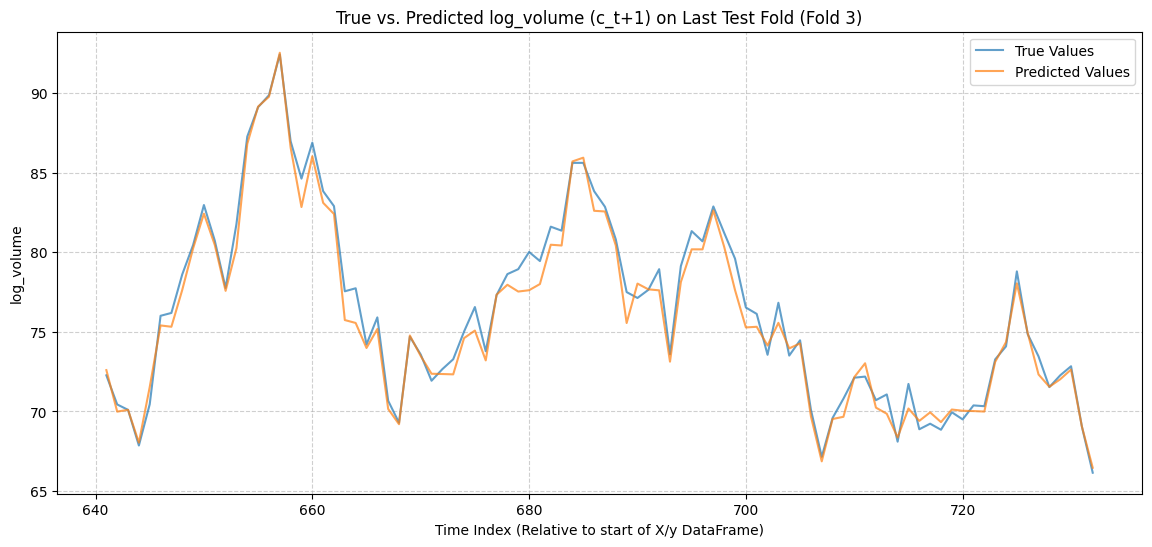

In [41]:
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)

test_rmses = []
last_fold_true = None
last_fold_pred = None

for fold, (train_index_full, test_index_full) in enumerate(tscv.split(X)):
    X_train_fold_full, y_train_fold_full = X.iloc[train_index_full], y.iloc[train_index_full]
    X_test_fold_full, y_test_fold_full = X.iloc[test_index_full], y.iloc[test_index_full]

    test_fold_length = len(X_test_fold_full)
    val_length = test_fold_length // 2

    X_test_final = X_test_fold_full.iloc[val_length:]
    y_test_final = y_test_fold_full.iloc[val_length:]

    best_model = xgb.XGBRegressor(n_estimators=int(best_n_estimators),
                                       reg_alpha=best_alpha,
                                       random_state=42,
                                       n_jobs=-1)

    best_model.fit(X_train_fold_full, np.ravel(y_train_fold_full))

    y_pred_test = best_model.predict(X_test_final)

    test_rmse = np.sqrt(mean_squared_error(y_test_final, y_pred_test))
    test_rmses.append(test_rmse)

    if fold == n_splits - 1:
        last_fold_true = y_test_final.values
        last_fold_pred = y_pred_test
        last_fold_index = y_test_final.index

print("Test set RMSE for each fold:")
for i, rmse in enumerate(test_rmses):
    print(f"  Fold {i+1}: {rmse}")

print(f"RMSE of Best Fitting Model: {np.mean(test_rmses)}")


if last_fold_true is not None and last_fold_pred is not None:
    plt.figure(figsize=(14, 6))
    plt.plot(last_fold_index, last_fold_true, label='True Values', alpha=0.7)
    plt.plot(last_fold_index, last_fold_pred, label='Predicted Values', alpha=0.7)
    plt.title(f'True vs. Predicted log_volume (c_t+1) on Last Test Fold (Fold {n_splits})')
    plt.xlabel('Time Index (Relative to start of X/y DataFrame)')
    plt.ylabel('log_volume')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

C:\Users\evans\AppData\Local\Temp\ipykernel_59240\228438546.py:33: FutureWarning:

Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.

C:\Users\evans\AppData\Local\Temp\ipykernel_59240\228438546.py:33: FutureWarning:

Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.

C:\Users\evans\AppData\Local\Temp\ipykernel_59240\228438546.py:33: FutureWarning:

Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.

C:\Users\evans\AppData\Local\Temp\ipykernel_59240\228438546.py:33: FutureWarning:

Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.

C:\Users\evans\AppData\Local\Temp\ipykernel_59240\228438546.py:3

Optimal Parameters: (200, 0.001)
Minimum RMSE (Validation): [np.float64(32.77348162723244), np.float64(3.0285091243811695), np.float64(4.26987240916161)]


C:\Users\evans\AppData\Local\Temp\ipykernel_59240\228438546.py:48: FutureWarning:

Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.

C:\Users\evans\AppData\Local\Temp\ipykernel_59240\228438546.py:48: FutureWarning:

Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.

C:\Users\evans\AppData\Local\Temp\ipykernel_59240\228438546.py:48: FutureWarning:

Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.



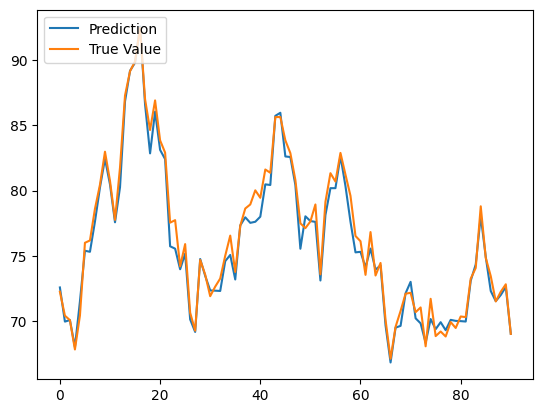

Minimum RMSE (test): 10.336883264461624


In [42]:
def time_series_valid_test(X, y, n_split, valid_or_test, n_estimators_list, ccp_alpha_list, optimal_par=None):
    np.random.seed(42)
    tscv = TimeSeriesSplit(n_splits=n_split)
    rf_rmse = []
    rmseSmall = []
    param_combinations = []  # param combo storagae
    i = 0  # fold counter
    for train_index, test_index in tscv.split(X):
        i += 1
        # Break test set into 50% validation set, 50% test set
        break_test_ind = int(test_index[0] + 0.5*(test_index[-1]-test_index[0]))
        valid_index = np.array(list(range(test_index[0],break_test_ind)))
        test_index = np.array(list(range(break_test_ind,test_index[-1])))

        # Split data into training, validation, and test sets
        X_train, X_valid, X_test = X.iloc[train_index], X.iloc[valid_index], X.iloc[test_index]
        y_train, y_valid, y_test = y.iloc[train_index], y.iloc[valid_index], y.iloc[test_index]

        # Tuning
        if valid_or_test == "valid":
            rf_rmse_fold = []
            for n_estimators in n_estimators_list:
                for ccp_alpha in ccp_alpha_list:
                    model_rf = xgb.XGBRegressor(random_state=42,
                                                n_estimators=n_estimators,
                                                reg_alpha=ccp_alpha,
                                                n_jobs=-1)


                    X_train_sample = X_train.sample(frac=0.1, random_state=42)
                    y_train_sample = y_train.loc[X_train_sample.index]

                    model_rf.fit(X_train_sample, y_train_sample.ravel())


                    y_val_rf = model_rf.predict(X_valid)
                    fold_rmse = np.sqrt(mean_squared_error(y_valid, y_val_rf))
                    rf_rmse_fold.append(fold_rmse)
                    param_combinations.append((n_estimators, ccp_alpha))

            rf_rmse.append(np.mean(rf_rmse_fold))

        if valid_or_test == "test":
            model_rf = xgb.XGBRegressor(random_state=42,
                                             n_estimators=optimal_par[0],
                                             reg_alpha=optimal_par[1],
                                             n_jobs=-1)
            model_rf.fit(X_train, y_train.ravel())
            y_test_rf = model_rf.predict(X_test)
            test_rmse = np.sqrt(mean_squared_error(y_test, y_test_rf))
            rf_rmse.append(test_rmse)
            rmseSmall.append(np.sqrt(np.sum((y_test.shift(-1)[:-1] - y_test[:-1])**2)/len(y_test.shift(-1))))

            # Plot the prediction for the last CV fold
            if i == n_split:
                plt.plot(range(len(X_test)), y_test_rf, label="Prediction")
                plt.plot(range(len(X_test)), y_test, label="True Value")
                plt.legend(loc="upper left")
                plt.show()

    # Return results
    if valid_or_test == "valid":
        min_rmse_idx = np.argmin(rf_rmse)  # Find index of lowest RMSE
        optimal_params = param_combinations[min_rmse_idx]  # Retrieve corresponding parameters
        return rf_rmse, optimal_params
    if valid_or_test == "test":
        rf_rmse = np.mean(rf_rmse)
        rmseSmallAns = np.mean(rmseSmall)
        return rf_rmse, y_test_rf, rmseSmallAns

n_estimators_list = [200, 400, 600]
ccp_alpha_list = [10**-2, 10**-3, 10**-5, 10**-7]


rf_rmse, optimal_params = time_series_valid_test(X, y, n_split = 3, valid_or_test = "valid",
                                                 n_estimators_list = n_estimators_list,
                                                 ccp_alpha_list = ccp_alpha_list)


print("Optimal Parameters:", optimal_params)
print("Minimum RMSE (Validation):", rf_rmse)

test_rmse, preddictions, smallRMSE = time_series_valid_test(X, y, n_split = 3, valid_or_test = "test",
                                                 n_estimators_list = n_estimators_list,
                                                 ccp_alpha_list = ccp_alpha_list,
                                                 optimal_par=optimal_params)

print("Minimum RMSE (test):", test_rmse)